# Ecuación de difusión 1D en un dominio finito

La ecuación de difusión (o calor) en 1D en un intervalo finito esta dada por:
$$
u_t = k\,u_{xx}, \quad 0 < x < L,\quad t>0,
$$
Como primer modelo, consideraremos condiciones de frontera tipo Dirichlet homogéneas
$$
u(0,t) = 0, \quad u(L,t) = 0,
$$
y condición inicial dada por un modo sinusoidal
$$
u(x,0) = \sin\left(\frac{\pi x}{L}\right).
$$

Este problema tiene una solución exacta muy simple:
$$
u(x,t) = e^{-k\left(\frac{\pi}{L}\right)^2 t}\,\sin\left(\frac{\pi x}{L}\right),
$$
lo que nos permitirá comparar la solución numérica que obtengamos con diferencias finitas contra la solución analítica.


# Discretización en espacio y tiempo

### Malla espacial

Dividimos el intervalo $[0,L]$ en $N$ subintervalos de tamaño $\Delta x$:
$$
x_j = j\,\Delta x, \quad j=0,1,\dots,N,\qquad \Delta x = \frac{L}{N}.
$$

En estos puntos aproximamos la solución continua $u(x,t)$ por valores discretos:
$$
u_j^n \approx u(x_j, t^n),
$$
donde $t^n = n\,\Delta t$ será la malla temporal.

### Aproximación de derivadas

- Derivada temporal (diferencia hacia adelante):
$$
u_t(x_j,t^n) \approx \frac{u_j^{n+1} - u_j^n}{\Delta t}.
$$

- Segunda derivada espacial (diferencias centrales):
$$
u_{xx}(x_j,t^n) \approx \frac{u_{j+1}^n - 2u_j^n + u_{j-1}^n}{\Delta x^2}.
$$

Sustituyendo en la ecuación $u_t = k u_{xx}$, obtenemos el esquema explícito (FTCS):
$$
\frac{u_j^{n+1} - u_j^n}{\Delta t}
= k\,\frac{u_{j+1}^n - 2u_j^n + u_{j-1}^n}{\Delta x^2}.
$$

Despejando $u_j^{n+1}$:
$$
u_j^{n+1} = u_j^n + \lambda \left( u_{j+1}^n - 2u_j^n + u_{j-1}^n \right),
$$
donde
$$
\lambda = k \frac{\Delta t}{\Delta x^2}.
$$

Este esquema se aplica para los nodos interiores $j = 1,2,\dots,N-1$.


### Condiciones de frontera

Como tenemos
$$
u(0,t) = 0, \quad u(L,t) = 0,
$$
en la malla esto se traduce en
$$
u_0^n = 0, \quad u_N^n = 0 \quad \text{para todo } n.
$$

### Condición inicial

Tomamos
$$
u(x,0) = \sin\left(\frac{\pi x}{L}\right),
$$
luego en la malla
$$
u_j^0 = \sin\left(\frac{\pi x_j}{L}\right).
$$

## Condición de estabilidad (CFL)

El esquema explícito FTCS para la ecuación de difusión es condicionalmente estable.  
La condición de estabilidad (tipo CFL) es
$$
\lambda = k \frac{\Delta t}{\Delta x^2} \leq \frac{1}{2}.
$$

En la práctica:

- Elegimos $N$ (número de subintervalos) y, por tanto, $\Delta x$.
- Fijamos $k$ (coeficiente de difusión).
- Elegimos $\Delta t$ de modo que se cumpla
  $$ 
  \Delta t \leq \frac{1}{2}\,\frac{\Delta x^2}{k}.
  $$

En el código haremos que $\Delta t$ sea un poco menor que este límite para estar del lado estable.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

def condicion_inicial_seno(x, L):
    """
    Calcula la condición inicial u(x,0) = sin(pi x / L).
    
    Parámetros
    ----------
    x : ndarray
        Arreglo con los puntos de la malla espacial.
    L : float
        Longitud del dominio [0, L].
    
    Regresa
    -------
    ndarray
        Valores de la condición inicial en cada punto de la malla.
    """
    return np.sin(np.pi * x / L)


def solucion_exacta_seno(x, t, kappa, L):
    """
    Calcula la solución exacta del problema de difusión con modo sinusoidal:
    
        u(x,t) = exp(-kappa (pi/L)^2 t) * sin(pi x / L)
    
    Parámetros
    ----------
    x : ndarray
        Puntos de la malla espacial.
    t : float
        Tiempo en el que se evalúa la solución exacta.
    kappa : float
        Coeficiente de difusión k.
    L : float
        Longitud del dominio.
    
    Regresa
    -------
    ndarray
        Valores de la solución exacta en cada punto de la malla.
    """
    factor = np.exp(-kappa * (np.pi / L) ** 2 * t)
    return factor * np.sin(np.pi * x / L)


def simular_difusion_seno(kappa, L, N, dt, t_final):
    """
    Simula la ecuación de difusión 1D con condiciones de frontera 
    u(0,t) = 0, u(L,t) = 0 y condición inicial u(x,0) = sin(pi x / L),
    usando el esquema explícito de diferencias finitas (FTCS).
    
    Parámetros
    ----------
    kappa : float
        Coeficiente de difusión k.
    L : float
        Longitud del dominio [0, L].
    N : int
        Número de subintervalos espaciales (habrá N+1 nodos).
    dt : float
        Paso de tiempo.
    t_final : float
        Tiempo final de la simulación.
    
    Regresa
    -------
    x : ndarray
        Puntos de la malla espacial.
    tiempos : ndarray
        Arreglo con los tiempos en los que se guardó la solución.
    soluciones : ndarray
        Arreglo de tamaño (num_tiempos, N+1) con las soluciones numéricas
        u_j^n en cada tiempo guardado.
    """
    # Malla espacial
    dx = L / N
    x = np.linspace(0.0, L, N + 1)
    
    # Parámetro lambda = k dt / dx^2
    lam = kappa * dt / dx**2
    if lam > 0.5:
        print(f"ADVERTENCIA: lambda = {lam:.3f} > 0.5, el esquema puede ser inestable.")
    
    # Número de pasos de tiempo
    num_pasos = int(np.round(t_final / dt))
    
    # Estado inicial
    u = condicion_inicial_seno(x, L)
    
    # Lista para almacenar la solución en ciertos tiempos
    # Por simplicidad, guardamos en todos los pasos
    soluciones = [u.copy()]
    tiempos = [0.0]
    
    # Bucle en el tiempo
    for n in range(1, num_pasos + 1):
        u_nuevo = u.copy()
        
        # Actualización en los nodos interiores usando FTCS
        for j in range(1, N):
            u_nuevo[j] = (
                u[j]
                + lam * (u[j + 1] - 2.0 * u[j] + u[j - 1])
            )
        
        # Condiciones de frontera Dirichlet homogéneas
        u_nuevo[0] = 0.0
        u_nuevo[N] = 0.0
        
        # Actualizar solución
        u = u_nuevo
        
        # Guardar solución y tiempo actual
        t_actual = n * dt
        soluciones.append(u.copy())
        tiempos.append(t_actual)
    
    return x, np.array(tiempos), np.array(soluciones)


In [2]:
# Parámetros físicos y numéricos

kappa = 1.0       # coeficiente de difusión k
L = 1.0           # longitud del dominio [0, L]
N = 50            # número de subintervalos espaciales (N+1 nodos)

dx = L / N

# Elegimos dt usando la condición de estabilidad lambda <= 0.5
lambda_max = 0.5
dt = 0.4 * dx**2 / kappa  # un poco por debajo del límite

t_final = 0.2  # tiempo final de la simulación

# Ejecutamos la simulación
x, tiempos, soluciones = simular_difusion_seno(kappa, L, N, dt, t_final)


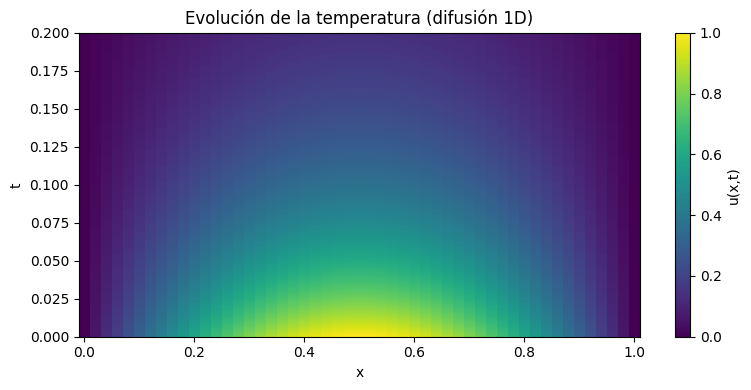

In [3]:
# Visualización de resultados: evolución de la temperatura en el espacio-tiempo
plt.figure(figsize=(8, 4))
T, X = np.meshgrid(tiempos, x, indexing='ij')

# soluciones tiene forma (num_tiempos, N+1), ya compatible con T, X
plt.pcolormesh(X, T, soluciones, shading='auto', cmap=cm.viridis)
plt.colorbar(label="u(x,t)")
plt.xlabel("x")
plt.ylabel("t")
plt.title("Evolución de la temperatura (difusión 1D)")
plt.tight_layout()
plt.show()


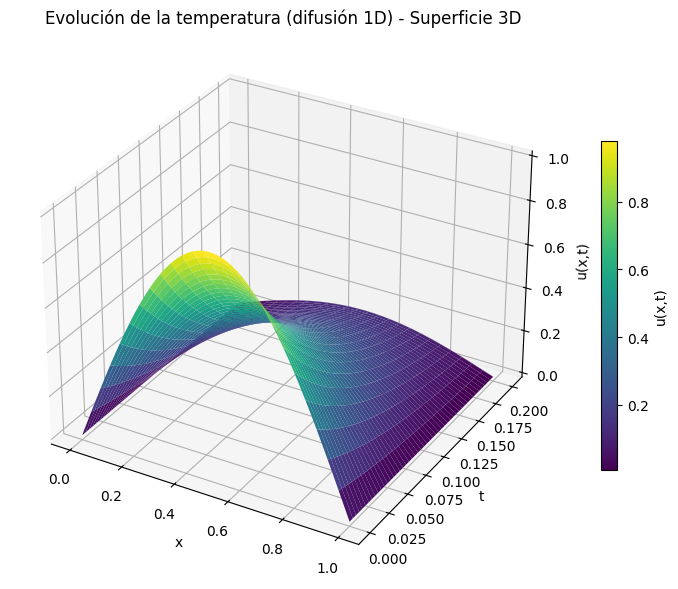

In [4]:
from mpl_toolkits.mplot3d import Axes3D  # necesario para activar 3D en algunos entornos

# Crear malla espacio–tiempo
T, X = np.meshgrid(tiempos, x, indexing='ij')

fig = plt.figure(figsize=(9, 6))
ax = fig.add_subplot(111, projection="3d")

# Superficie 3D usando el mismo mapa de color que el mapa de calor
surf = ax.plot_surface(
    X,           # eje x (espacio)
    T,           # eje y (tiempo)
    soluciones,  # eje z (u(x,t))
    cmap=cm.viridis,
    linewidth=0,
    antialiased=True
)

ax.set_xlabel("x")
ax.set_ylabel("t")
ax.set_zlabel("u(x,t)")
ax.set_title("Evolución de la temperatura (difusión 1D) - Superficie 3D")

fig.colorbar(surf, ax=ax, shrink=0.6, label="u(x,t)")

plt.tight_layout()
plt.show()


interactive(children=(IntSlider(value=0, description='Paso de tiempo', max=1250), Output()), _dom_classes=('wi…

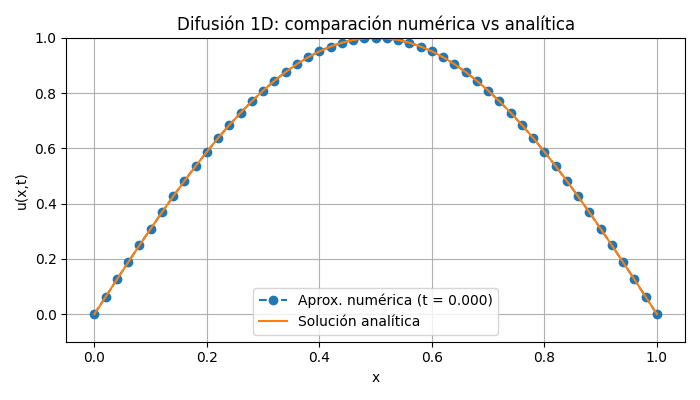

In [5]:
from ipywidgets import interact, IntSlider
%matplotlib widget
# Crear figura y ejes UNA sola vez
fig, ax = plt.subplots(figsize=(7, 4))

# Curvas iniciales en t = 0
t0 = tiempos[0]
u_num0 = soluciones[0, :]
u_ex0 = solucion_exacta_seno(x, t0, kappa, L)

linea_num, = ax.plot(
    x, u_num0, marker='o', linestyle='--',
    label=f"Aprox. numérica (t = {t0:.3f})"
)
linea_ex, = ax.plot(
    x, u_ex0, linestyle='-',
    label="Solución analítica"
)

ax.set_xlabel("x")
ax.set_ylabel("u(x,t)")
ax.set_title("Difusión 1D: comparación numérica vs analítica")
ax.grid(True)
ax.legend()
ax.set_ylim(-0.1, 1.0)
fig.tight_layout()

def actualizar(indice):
    """
    Actualiza las curvas numérica y analítica en el tiempo tiempos[indice]
    sin crear figuras nuevas (evita flickering).
    """
    t = tiempos[indice]
    u_num = soluciones[indice, :]
    u_ex = solucion_exacta_seno(x, t, kappa, L)
    
    # Actualizar datos de las curvas
    linea_num.set_ydata(u_num)
    linea_num.set_label(f"Aprox. numérica (t = {t:.3f})")
    linea_ex.set_ydata(u_ex)
    
    # Actualizar leyenda (porque cambia el label de la numérica)
    ax.legend(loc="best")
    
    # Redibujar de forma eficiente
    fig.canvas.draw_idle()

# Slider para elegir el tiempo (por índice)
interact(
    actualizar,
    indice=IntSlider(
        min=0,
        max=len(tiempos) - 1,
        step=1,
        value=0,
        description="Paso de tiempo"
    )
);


## Condiciones de frontera de Neumann

Hasta ahora hemos considerado la ecuación de difusión (o calor) en 1D en un intervalo finito
$$
u_t = k\,u_{xx}, \quad 0 < x < L,\quad t>0,
$$
con condiciones de frontera tipo Dirichlet (temperatura fijada) $u(0,t)=0$, $u(L,t)=0$.

Ahora introducimos **condiciones de frontera de Neumann**:

$$
u_x(0,t) = 0, \qquad u_x(L,t) = 0.
$$

### Interpretación física de las fronteras de Neumann

- Esto significa que **no hay flujo de calor a través de los extremos** de la barra.
- Físicamente: los extremos están **perfectamente aislados térmicamente**. El calor puede difundirse dentro de la barra, pero **no puede salir ni entrar** por $x=0$ ni por $x=L$.

Una consecuencia importante es que la **energía total** (proporcional a la integral de la temperatura) se conserva:
$$
E(t) = \int_0^L u(x,t)\,dx, \qquad \frac{dE}{dt} = 0
$$
bajo estas condiciones de Neumann homogéneas.  
En particular, el **promedio de temperatura**
$$
\bar u(t) = \frac{1}{L} \int_0^L u(x,t)\,dx
$$
permanece constante en el tiempo. A largo plazo, la solución se hace cada vez más uniforme por difusión y termina en un estado de equilibrio:
$$
u(x,t) \;\longrightarrow\; \bar u(0),
$$
es decir, una temperatura constante igual al promedio inicial.

## Estrategia numérica con condiciones de Neumann (método de diferencias finitas)

Usaremos la misma discretización espacial que antes:

- Dominio $[0,L]$ dividido en $N$ subintervalos:
  $$
  x_j = j\,\Delta x,\quad j=0,1,\dots,N,\qquad \Delta x = \frac{L}{N}.
  $$
- Aproximamos $u(x_j,t^n)$ por $u_j^n$.

En el interior ($j=1,\dots,N-1$) seguimos usando el esquema explícito FTCS:
$$
\frac{u_j^{n+1} - u_j^n}{\Delta t}
= k\,\frac{u_{j+1}^n - 2u_j^n + u_{j-1}^n}{\Delta x^2},
$$
es decir
$$
u_j^{n+1} = u_j^n
+ \lambda\big(u_{j+1}^n - 2u_j^n + u_{j-1}^n\big),
\qquad \lambda = k\frac{\Delta t}{\Delta x^2}.
$$

El reto está en los nodos de la frontera $j=0$ y $j=N$, porque ahí la fórmula de segunda derivada
$$
u_{xx}(x_j,t) \approx \frac{u_{j+1}^n - 2u_j^n + u_{j-1}^n}{\Delta x^2}
$$
necesita un punto fuera del dominio ($u_{-1}$ o $u_{N+1}$).

### 1. Introducción de puntos fantasmas

La idea del **punto fantasma** es extender ficticiamente la malla fuera del dominio físico:

- A la izquierda: un nodo en $x_{-1} = -\Delta x$ con valor $u_{-1}^n$.
- A la derecha: un nodo en $x_{N+1} = L + \Delta x$ con valor $u_{N+1}^n$.

Estos valores no se calculan con la ecuación de difusión, sino que se determinan a partir de la **condición de Neumann**.

En $x=0$:
$$
u_x(0,t) = 0 \;\Rightarrow\;
u_x(0,t^n) \approx \frac{u_1^n - u_{-1}^n}{2\Delta x} = 0
\;\Rightarrow\;
u_{-1}^n = u_1^n.
$$

En $x=L$:
$$
u_x(L,t) = 0 \;\Rightarrow\;
u_x(L,t^n) \approx \frac{u_{N+1}^n - u_{N-1}^n}{2\Delta x} = 0
\;\Rightarrow\;
u_{N+1}^n = u_{N-1}^n.
$$

Es decir, **imponemos simetría** del campo de temperatura respecto a la frontera: el valor “fuera” del dominio es igual al del nodo interior simétrico.

### 2. Fórmulas actualizadas en los nodos de frontera

Una vez que tenemos $u_{-1}^n$ y $u_{N+1}^n$ en función de los nodos interiores, podemos usar la misma fórmula de la segunda derivada en $j=0$ y $j=N$.

En $j=0$:
$$
u_0^{n+1}
= u_0^n + \lambda\big(u_1^n - 2u_0^n + u_{-1}^n\big).
$$
Sustituyendo $u_{-1}^n = u_1^n$:
$$
u_0^{n+1}
= u_0^n + \lambda\big(u_1^n - 2u_0^n + u_1^n\big)
= u_0^n + 2\lambda\,(u_1^n - u_0^n).
$$

En $j=N$:
$$
u_N^{n+1}
= u_N^n + \lambda\big(u_{N+1}^n - 2u_N^n + u_{N-1}^n\big),
$$
y usando $u_{N+1}^n = u_{N-1}^n$:
$$
u_N^{n+1}
= u_N^n + \lambda\big(u_{N-1}^n - 2u_N^n + u_{N-1}^n\big)
= u_N^n + 2\lambda\,(u_{N-1}^n - u_N^n).
$$

Así, el esquema completo queda:

- Para $j=1,\dots,N-1$ (interior):
  $$
  u_j^{n+1} = u_j^n
  + \lambda\big(u_{j+1}^n - 2u_j^n + u_{j-1}^n\big).
  $$
- Para $j=0$ (frontera izquierda, Neumann):
  $$
  u_0^{n+1} = u_0^n + 2\lambda\,(u_1^n - u_0^n).
  $$
- Para $j=N$ (frontera derecha, Neumann):
  $$
  u_N^{n+1} = u_N^n + 2\lambda\,(u_{N-1}^n - u_N^n).
  $$

### 3. Comentarios sobre la conservación de energía y estabilidad

- Este tratamiento con puntos fantasmas respeta la idea física de **no flujo de calor** en los bordes.
- A nivel discreto, se puede verificar que, bajo este esquema, la suma
  $$
  \sum_{j=0}^N u_j^n
  $$
  se mantiene aproximadamente constante en el tiempo (salvo errores de redondeo), reflejando la **conservación de la energía** en una barra aislada.
- La condición de estabilidad del esquema explícito sigue siendo, de forma aproximada,
  $$
  \lambda = k\frac{\Delta t}{\Delta x^2} \leq \frac{1}{2},
  $$
  igual que en el caso Dirichlet.

En resumen, la estrategia numérica es:

1. **Usar FTCS** en los nodos interiores, igual que antes.
2. **Introducir puntos fantasmas** fuera del dominio.
3. **Imponer las condiciones de Neumann** para escribir los puntos fantasmas en términos de los nodos interiores.
4. **Sustituir esos valores** en la fórmula de actualización de los nodos de frontera, obteniendo expresiones explícitas para $u_0^{n+1}$ y $u_N^{n+1}$.

Con esta idea, podemos reutilizar casi todo el código del caso Dirichlet y cambiar sólo la parte donde actualizamos los nodos de frontera.


In [6]:
def condicion_inicial_dirac_discreta(x, A=10.0):
    """
    Condición inicial tipo 'delta discreta':
    todos los nodos en cero excepto el nodo central, que vale A.
    """
    u0 = np.zeros_like(x)
    j0 = len(x) // 2  # nodo central
    u0[j0] = A
    return u0


In [7]:
def simular_difusion_dirac_neumann(kappa, L, N, dt, t_final, A=10.0):
    """
    Simula la ecuación de difusión 1D con fronteras aislantes (Neumann homogénea):
        u_x(0,t) = 0, u_x(L,t) = 0
    y condición inicial tipo delta discreta en el nodo central.
    
    Se usa el esquema explícito FTCS con puntos fantasmas para Neumann.
    """
    dx = L / N
    x = np.linspace(0.0, L, N + 1)
    
    lam = kappa * dt / dx**2
    print(f"dx = {dx:.4f}, dt = {dt:.6f}, lambda = {lam:.4f}")
    if lam > 0.5:
        print("ADVERTENCIA: lambda > 0.5, el esquema explícito puede ser inestable.")
    
    num_pasos = int(np.round(t_final / dt))
    
    # condición inicial: delta discreta
    u = condicion_inicial_dirac_discreta(x, A=A)
    
    soluciones = [u.copy()]
    tiempos = [0.0]
    
    for n in range(1, num_pasos + 1):
        u_nuevo = u.copy()
        
        # Nodos interiores: j = 1,...,N-1
        for j in range(1, N):
            u_nuevo[j] = u[j] + lam * (u[j+1] - 2.0*u[j] + u[j-1])
        
        # Fronteras Neumann homogéneas usando puntos fantasmas:
        # u_x(0,t) = 0  =>  u_{-1} = u_1
        # u_x(L,t) = 0  =>  u_{N+1} = u_{N-1}
        # Fórmulas resultantes:
        # u_0^{n+1} = u_0^n + 2*lam*(u_1^n - u_0^n)
        # u_N^{n+1} = u_N^n + 2*lam*(u_{N-1}^n - u_N^n)
        u_nuevo[0] = u[0] + 2.0 * lam * (u[1] - u[0])
        u_nuevo[N] = u[N] + 2.0 * lam * (u[N-1] - u[N])
        
        u = u_nuevo
        t_actual = n * dt
        soluciones.append(u.copy())
        tiempos.append(t_actual)
    
    return x, np.array(tiempos), np.array(soluciones)


# Parámetros físicos y numéricos
kappa = 1.0
L = 1.0
N = 50

dx = L / N
dt = 0.4 * dx**2 / kappa
t_final = 0.2

# Ejecutar simulación con delta discreta y fronteras de Neumann
x_neu, tiempos_neu, soluciones_neu = simular_difusion_dirac_neumann(
    kappa, L, N, dt, t_final, A=10.0
)


dx = 0.0200, dt = 0.000160, lambda = 0.4000


interactive(children=(IntSlider(value=0, description='Paso de tiempo', max=1250), Output()), _dom_classes=('wi…

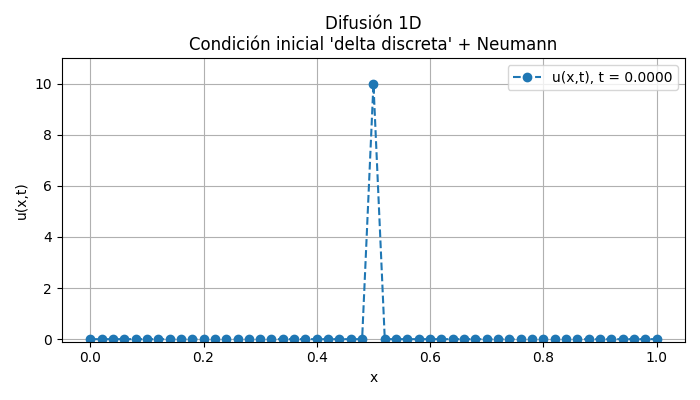

In [8]:
%matplotlib widget
# Creamos la figura y el eje UNA sola vez
fig, ax = plt.subplots(figsize=(7, 4))

# Curva inicial (en t = 0)
linea, = ax.plot(x_neu, soluciones_neu[0, :], marker='o', linestyle='--',
                 label=f"u(x,t), t = {tiempos_neu[0]:.4f}")

ax.set_xlabel("x")
ax.set_ylabel("u(x,t)")
ax.set_title("Difusión 1D\nCondición inicial 'delta discreta' + Neumann")
ax.grid(True)
ax.legend()
ax.set_ylim(-0.1, 1.1 * soluciones_neu.max())
fig.tight_layout()

def actualizar(indice):
    """
    Actualiza SOLO los datos de la curva y el título.
    No crea figuras nuevas.
    """
    t = tiempos_neu[indice]
    u_num = soluciones_neu[indice, :]
    
    linea.set_ydata(u_num)
    linea.set_label(f"u(x,t), t = {t:.4f}")
    ax.legend(loc="best")
    ax.set_title("Difusión 1D\nCondición inicial 'delta discreta' + Neumann")
    
    # Redibuja de forma eficiente (evita flickering)
    fig.canvas.draw_idle()

interact(
    actualizar,
    indice=IntSlider(
        min=0,
        max=len(tiempos_neu) - 1,
        step=1,
        value=0,
        description="Paso de tiempo"
    )
);

interactive(children=(IntSlider(value=0, description='Paso de tiempo', max=625), Output()), _dom_classes=('wid…

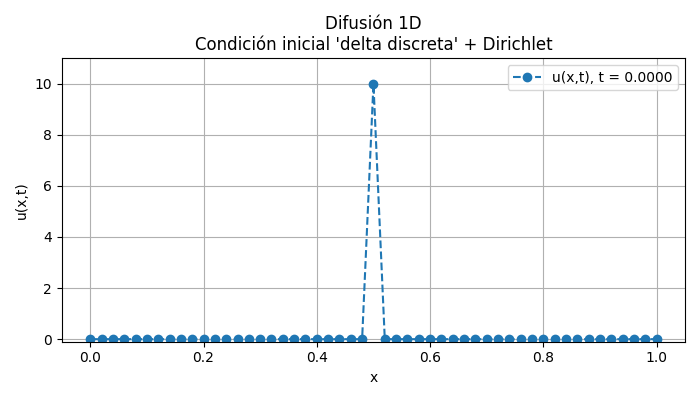

In [9]:
from ipywidgets import interact, IntSlider

def simular_difusion_dirac_dirichlet(kappa, L, N, dt, t_final, A=10.0):
    """
    Simula la ecuación de difusión 1D con condiciones de frontera
    u(0,t) = 0, u(L,t) = 0 y condición inicial tipo 'dirac discreta'
    (un solo nodo central con valor A), usando FTCS.
    """
    dx = L / N
    x = np.linspace(0.0, L, N + 1)
    
    lam = kappa * dt / dx**2
    if lam > 0.5:
        print(f"ADVERTENCIA: lambda = {lam:.3f} > 0.5, el esquema puede ser inestable.")
    
    num_pasos = int(np.round(t_final / dt))
    
    # condición inicial: delta discreta
    u = condicion_inicial_dirac_discreta(x, A=A)
    
    soluciones = [u.copy()]
    tiempos = [0.0]
    
    for n in range(1, num_pasos + 1):
        u_nuevo = u.copy()
        
        # nodos interiores
        for j in range(1, N):
            u_nuevo[j] = u[j] + lam * (u[j+1] - 2.0*u[j] + u[j-1])
        
        # fronteras Dirichlet homogéneas
        u_nuevo[0] = 0.0
        u_nuevo[N] = 0.0
        
        u = u_nuevo
        t_actual = n * dt
        soluciones.append(u.copy())
        tiempos.append(t_actual)
    
    return x, np.array(tiempos), np.array(soluciones)

# Parámetros (puedes ajustarlos si quieres)
kappa = 1.0
L = 1.0
N = 50

dx = L / N
dt = 0.4 * dx**2 / kappa
t_final = 0.1

# Ejecutar simulación con delta discreta
x_dirac, tiempos_dirac, soluciones_dirac = simular_difusion_dirac_dirichlet(
    kappa, L, N, dt, t_final, A=10.0
)

# Creamos la figura y el eje UNA sola vez
fig, ax = plt.subplots(figsize=(7, 4))

# Curva inicial (en t = 0)
linea, = ax.plot(x_dirac, soluciones_dirac[0, :], marker='o', linestyle='--',
                 label=f"u(x,t), t = {tiempos_dirac[0]:.4f}")

ax.set_xlabel("x")
ax.set_ylabel("u(x,t)")
ax.set_title("Difusión 1D\nCondición inicial 'delta discreta' + Dirichlet")
ax.grid(True)
ax.legend()
ax.set_ylim(-0.1, 1.1 * soluciones_neu.max())
fig.tight_layout()

# Función de graficación interactiva
def actualizar(indice):
        """
    Actualiza SOLO los datos de la curva y el título.
    No crea figuras nuevas.
    """
        t = tiempos_dirac[indice]
        u_num = soluciones_dirac[indice, :]
        
        linea.set_ydata(u_num)
        linea.set_label(f"u(x,t), t = {t:.4f}")
        ax.legend(loc="best")
        ax.set_title("Difusión 1D\nCondición inicial 'delta discreta' + Dirichlet")
        
        # Redibuja de forma eficiente (evita flickering)
        fig.canvas.draw_idle()

interact(
    actualizar,
    indice=IntSlider(
        min=0,
        max=len(tiempos_dirac) - 1,
        step=1,
        value=0,
        description="Paso de tiempo"
    )
);
 